<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Посмотрим на данные. В первых ячейках будут импорты библиотек. Далее откроем файл с помощью пандас. Проведем первое знакомство. Посмортим есть ли дубликаты, выведем часть нашего дата сета на экран и посмотрим что у нас есть.

In [1]:
!pip install catboost
!pip install nltk

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrejkazancev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 188.3 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [18]:
toxic = pd.read_csv('/datasets/toxic_comments.csv')

In [19]:
#file_path ='/Users/andrejkazancev/Desktop/toxic_comments.csv'

In [20]:
#toxic = pd.read_csv(file_path)

In [21]:
toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [22]:
toxic.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
toxic.duplicated().sum()

0

In [9]:
toxic['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

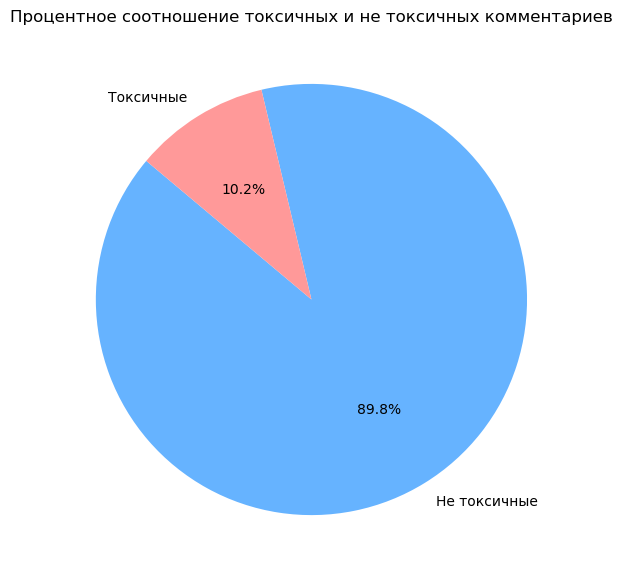

In [10]:
toxic_counts = toxic['toxic'].value_counts()
toxic_df = toxic_counts.rename_axis('toxic').reset_index(name='count')
toxic_df['percentage'] = (toxic_df['count'] / toxic_df['count'].sum()) * 100
colors = ['#66b3ff', '#ff9999']  # Можете изменить на предпочтительные
plt.figure(figsize=(7, 7))
plt.pie(toxic_df['percentage'], labels = ['Не токсичные', 'Токсичные'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Процентное соотношение токсичных и не токсичных комментариев')
plt.show()

In [11]:
toxic = toxic.drop(['Unnamed: 0'], axis=1)

In [12]:
#nltk.download('punkt')
#nltk.download('wordnet') 
#lemmatizer = WordNetLemmatizer()

#def clean_text(text):
#    clean = " ".join(re.sub(r'[^a-zA-z]', ' ', text).lower().split())
#    word_list = nltk.word_tokenize(clean)  # Uses punkt tokenizer
#    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
#    return lemmatized_output

#toxic['lemmatize'] = toxic['text'].apply(clean_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andrejkazancev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrejkazancev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 

Загрузили необходимые ресурсы библиотеки NLTK, создадим лемматизатор, очистим и лемматизируем тексты в датафрейме. Сохраним обработанные тексты в новом столбце.

In [23]:
import spacy

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    doc = nlp(text)
    lemmatized_output = ' '.join([token.lemma_ for token in doc])
    return lemmatized_output

toxic['lemmatize'] = toxic['text'].apply(clean_text)


In [24]:
toxic.head()

,Unnamed: 0,text,toxic,lemmatize
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation \n why the edit make under my user...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww ! he match this background colour I be s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,""" \n More \n I can not make any real suggestio..."
4,4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."


Итак, мы посмотрели на данные. Нет дубликатов. Есть странный столбик, удалили его. Посмотрели соотношение токсичных и не токсичных комментариев не токсичных 143106, токсичных 16186, в процентах 89,2% и 10,2% соответственно. Для наглядности построитли диаграмму pie. Очиситили и леммтизировали данные моделей. 

## Обучение

Выбрал 3 модели для обучения. Логистическую регрессию, Кэтбуст и Сулчайный лес. Приступим. Для начала, разделим на тренировочную и тестовую выборки. Потом обучим модели с подбором лучших гипперпараметров. Затем посмотрим нметрику F1 на тестовых данных.

In [25]:
train, test = train_test_split(toxic, test_size=0.1, random_state=12345)

target_train = train['toxic']
features_train = train['lemmatize']

target_test = test['toxic']
features_test = test['lemmatize']

In [26]:
stopwords_ = list(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords_)
tf_idf = count_tf_idf.fit_transform(tqdm(features_train))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143362/143362 [00:02<00:00, 67813.04it/s]


In [27]:
tf_idf.shape

(143362, 166345)

In [28]:
tf_idf_test = count_tf_idf.transform(features_test)
tf_idf_test.shape

(15930, 166345)

Обучим модель Логистической регрессии на тренировочных данных. Поскольку данные не сбалансированы, обязательно используем class_weight='balanced'.

In [35]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)

parameters = {
    'C': [5, 15],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 500],
}

lin_grid = GridSearchCV(model, parameters, scoring='f1', cv=3, n_jobs=-1)

In [36]:
lin_grid.fit(tf_idf, target_train)
lin_fit_score = lin_grid.best_score_
print(f'Лучший показатель F1: {lin_fit_score:.3f}')

Лучший показатель F1: 0.763


Обучим Кэтбуст и тоже получим метрику F1.

In [32]:
#catboost_model = CatBoostClassifier(iterations=400,
#                                    learning_rate=0.5,
#                                    depth=7,
#                                    loss_function='Logloss',
#                                    verbose=100,
#                                    eval_metric='F1',
#                                    task_type='CPU')
#
#catboost_model.fit(tf_idf, target_train, eval_set=(tf_idf_test, target_test), use_best_model=True)

0:	learn: 0.4242392	test: 0.4324844	best: 0.4324844 (0)	total: 1.14s	remaining: 7m 34s
100:	learn: 0.7863921	test: 0.7628940	best: 0.7633369 (99)	total: 1m 46s	remaining: 5m 16s
200:	learn: 0.8237229	test: 0.7690685	best: 0.7704280 (172)	total: 3m 29s	remaining: 3m 27s
300:	learn: 0.8375971	test: 0.7768827	best: 0.7780112 (260)	total: 5m 11s	remaining: 1m 42s
399:	learn: 0.8424236	test: 0.7785939	best: 0.7792935 (382)	total: 6m 49s	remaining: 0us

bestTest = 0.7792934593
bestIteration = 382

Shrink model to first 383 iterations.


In [39]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Создание экземпляра модели CatBoost
catboost_model = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='F1',
                                    task_type='CPU',
                                    verbose=100)

# Определение сетки гиперпараметров для поиска
param_grid = {'iterations': [200, 400],
              'learning_rate': [0.5],
              'depth': [5, 7]}

# Создание объекта GridSearchCV
grid = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='f1', cv=5)

# Подбор оптимальных гиперпараметров
grid.fit(tf_idf, target_train)

# Вывод параметров лучшей модели и ее оценки F1 на кросс-валидации
print("Параметры лучшей модели:", grid.best_params_)
print("Оценка F1 на кросс-валидации для лучших параметров:", grid.best_score_)

0:	learn: 0.4106032	total: 373ms	remaining: 1m 14s
100:	learn: 0.7685060	total: 20.4s	remaining: 20s
199:	learn: 0.8035296	total: 39.5s	remaining: 0us
0:	learn: 0.4667098	total: 304ms	remaining: 1m
100:	learn: 0.7723078	total: 19.8s	remaining: 19.4s
199:	learn: 0.8055839	total: 38.9s	remaining: 0us
0:	learn: 0.4019074	total: 278ms	remaining: 55.3s
100:	learn: 0.7696474	total: 19.8s	remaining: 19.4s
199:	learn: 0.8011974	total: 39.5s	remaining: 0us
0:	learn: 0.4670348	total: 300ms	remaining: 59.6s
100:	learn: 0.7683293	total: 19.8s	remaining: 19.4s
199:	learn: 0.8027456	total: 39s	remaining: 0us
0:	learn: 0.4587575	total: 300ms	remaining: 59.7s
100:	learn: 0.7708250	total: 19.9s	remaining: 19.5s
199:	learn: 0.8018725	total: 39.3s	remaining: 0us
0:	learn: 0.4106032	total: 300ms	remaining: 1m 59s
100:	learn: 0.7685060	total: 20.4s	remaining: 1m
200:	learn: 0.8038203	total: 41.1s	remaining: 40.7s
300:	learn: 0.8324247	total: 1m 3s	remaining: 21s
399:	learn: 0.8378700	total: 1m 23s	remainin

Обучим Случайный лес.

In [37]:
rf_model = RandomForestClassifier(random_state=12345)
rf_parameters = {
    'n_estimators': [5, 20],   
    'max_depth': [None, 10],      
    'min_samples_split': [2, 10], 
    'min_samples_leaf': [1, 4],   
}


cv = StratifiedKFold(n_splits=3)
rf_grid = GridSearchCV(rf_model, rf_parameters, scoring='f1', cv=cv, n_jobs=-1)
rf_grid.fit(tf_idf, target_train)
best_f1_rf = rf_grid.best_score_
best_params_rf = rf_grid.best_params_
print(f'Лучший показатель F1 для случайного леса: {best_f1_rf:.3f}')
print(f'Лучшие параметры для случайного леса: {best_params_rf}')

Лучший показатель F1 для случайного леса: 0.673
Лучшие параметры для случайного леса: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}


Сравним результаты на тестовой выборке

In [42]:
data = {'Модель': ['Логистическая регрессия', 'CatBoost', 'Случайный лес'],
        'F1 на кросс-валидации': [lin_fit_score, grid.best_score_, rf_grid.best_score_]}
results = pd.DataFrame(data)
results

,Модель,F1 на кросс-валидации
0,Логистическая регрессия,0.763443
1,CatBoost,0.762432
2,Случайный лес,0.673330


In [44]:
lr_pred = lin_grid.predict(tf_idf_test)
f1_lr = f1_score(target_test, lr_pred)
f1_lr

0.7653490328006729

## Выводы

###  Подготовка

Посмотрели на данные. Нет дубликатов. Есть странный столбик, удалили его. Посмотрели соотношение токсичных и не токсичных комментариев не токсичных 143106, токсичных 16186, в процентах 89,2% и 10,2% соответственно. Для наглядности построитли диаграмму pie. Очиситили и леммтизировали данные моделей. 

### Обучение

Обучили три модели: Логистическую регрессию, Кэтбуст и Сулчайный лес. Разделим на тренировочную и тестовую выборки. Обучили модели с подбором лучших гипперпараметров. Сравнили метрику на тестовых данных. 
Модель	F1 на кросс-валидации:    
* Логистическая регрессия	0.763443
* CatBoost	0.762432
* Случайный лес	0.673330

Лучше всего показала себя модель Логистической регресс, F1 - 0.763443. Обучили модель на тестовых данных получили метрику 0.7653490328006729


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны